<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/Visualizing%20Word2Vec%20Word%20Embeddings%20using%20t-SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Visualizaing Similar Words from Google News

In [ ]:

##Be patient...this will take some time to download!
import gensim.downloader as api
model = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import numpy as np
def linear_combination(word_scalars):
    """
    Perform a linear combination of word vectors.

    Parameters:
    - word_scalars (list of tuples): A list where each tuple contains a word (string) and a scalar (float or int).

    Returns:
    - np.array: The resulting vector from the linear combination.
    """
    # Initialize an empty vector for the result
    result_vector = np.zeros(model.vector_size)

    for word, scalar in word_scalars:
        # Check if the word is in the model
        if word in model:
            # Add (or subtract) the scaled vector to the result
            result_vector += model[word] * scalar
        else:
            print(f"Word '{word}' not in model vocabulary.")

    return result_vector



In [ ]:
# Example usage:
# Compute the vector for the expression: woman - 2*man + 3*girl
combination_vector = linear_combination([('calculus', 1), ('college', +2), ('biology', 1)])

# Find and print words most similar to the resulting vector
similar_words = model.most_similar(positive=[combination_vector], topn=5)
print(similar_words)

[('college', 0.7974893450737), ('calculus', 0.7319367527961731), ('biology', 0.6941104531288147), ('precalculus', 0.6479670405387878), ('pre_med', 0.6376080513000488)]


In [ ]:
keys = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<ipython-input-7-b04aadfc13d1>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


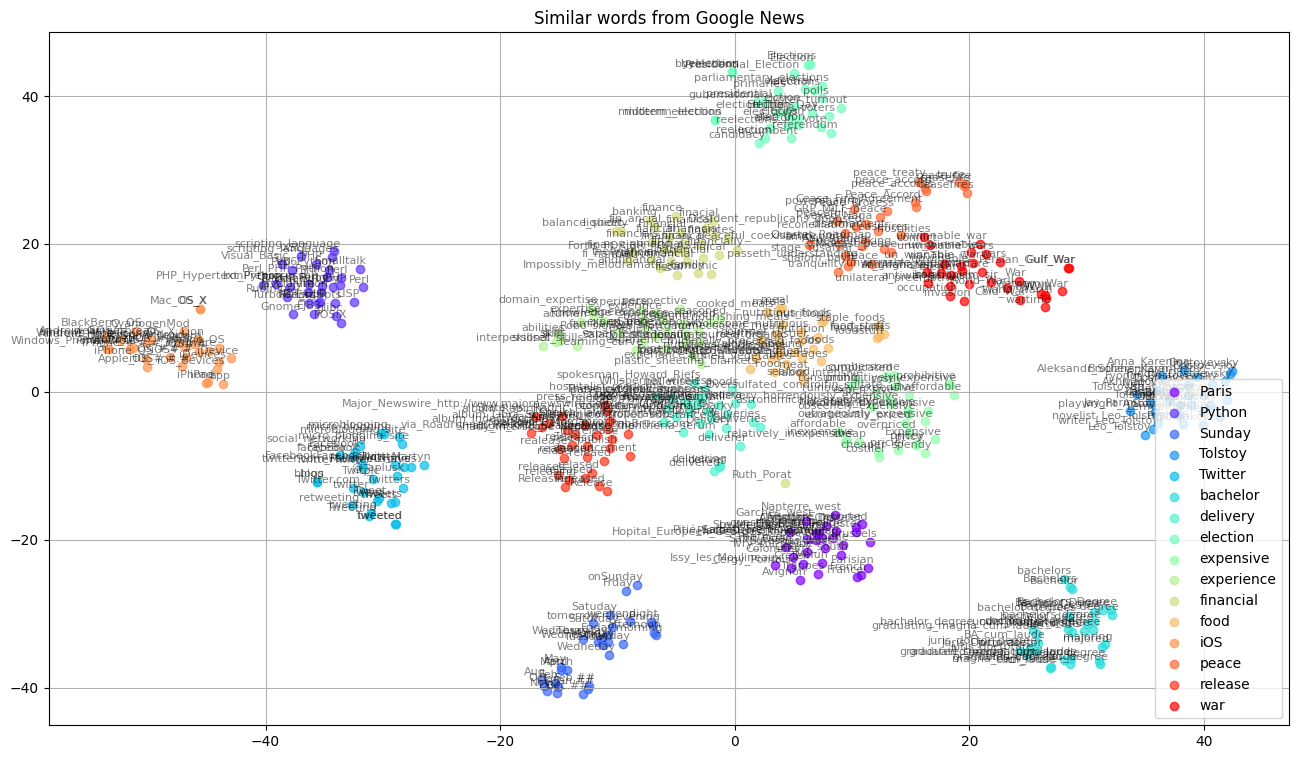

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib.cm as cm matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Visualizing Word2Vec Vectors from a novel in English

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
my_path="/content/drive/MyDrive/CS491/Data/"

In [23]:
import re
import gensim
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords if not already downloaded and convert to set for faster access
nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
stop_words=set()##do not remove stop words


# Modify the regular expression for non-alphanumeric characters removal to also remove newlines, carriage returns, and tabs
non_alpha_numeric_re = re.compile('[\n\r\t]|[^a-zA-Z0-9\s]+')

def preprocess_text(text):
    # Use the compiled regex to remove non-alphanumeric characters except for spaces, and also newlines, carriage returns, and tabs
    text = non_alpha_numeric_re.sub(' ', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords using the set for faster lookup
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Return the preprocessed text
    return ' '.join(filtered_words).strip()

def prepare_for_w2v(filename_from, filename_to, lang='english', use_sentence_tokenization=True):
    with open(filename_from, "r", encoding='utf-8') as file:
        raw_text = file.read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        # Check if sentence tokenization is used
        if use_sentence_tokenization:
            sentences = nltk.sent_tokenize(raw_text, language=lang)
        else:
            sentences = [raw_text]  # Treat the entire text as a single sentence

        for sentence in sentences:
            processed_sentence = preprocess_text(sentence.lower())
            print(processed_sentence, file=f)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, vector_size=300, window=10, min_count=3, workers=4)  # Adjusted workers to 4 for potential parallel processing improvement

# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

# Then, train the model as before
# model = train_word2vec('train_english_text.txt')

In [25]:
# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
prepare_for_w2v(my_path+'The Golden Bowl', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

model = train_word2vec('train_english_text.txt')

In [26]:
import numpy as np
from sklearn.manifold import TSNE

# Assuming model is your trained Word2Vec model from gensim

words_model = []
embeddings_model = []

for word in model.wv.key_to_index:
    embeddings_model.append(model.wv[word])
    words_model.append(word)

embeddings_model_np = np.array(embeddings_model)

# Initialize and apply TSNE
tsne_model_2d = TSNE(perplexity=64, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_model_2d_np = tsne_model_2d.fit_transform(embeddings_model_np)


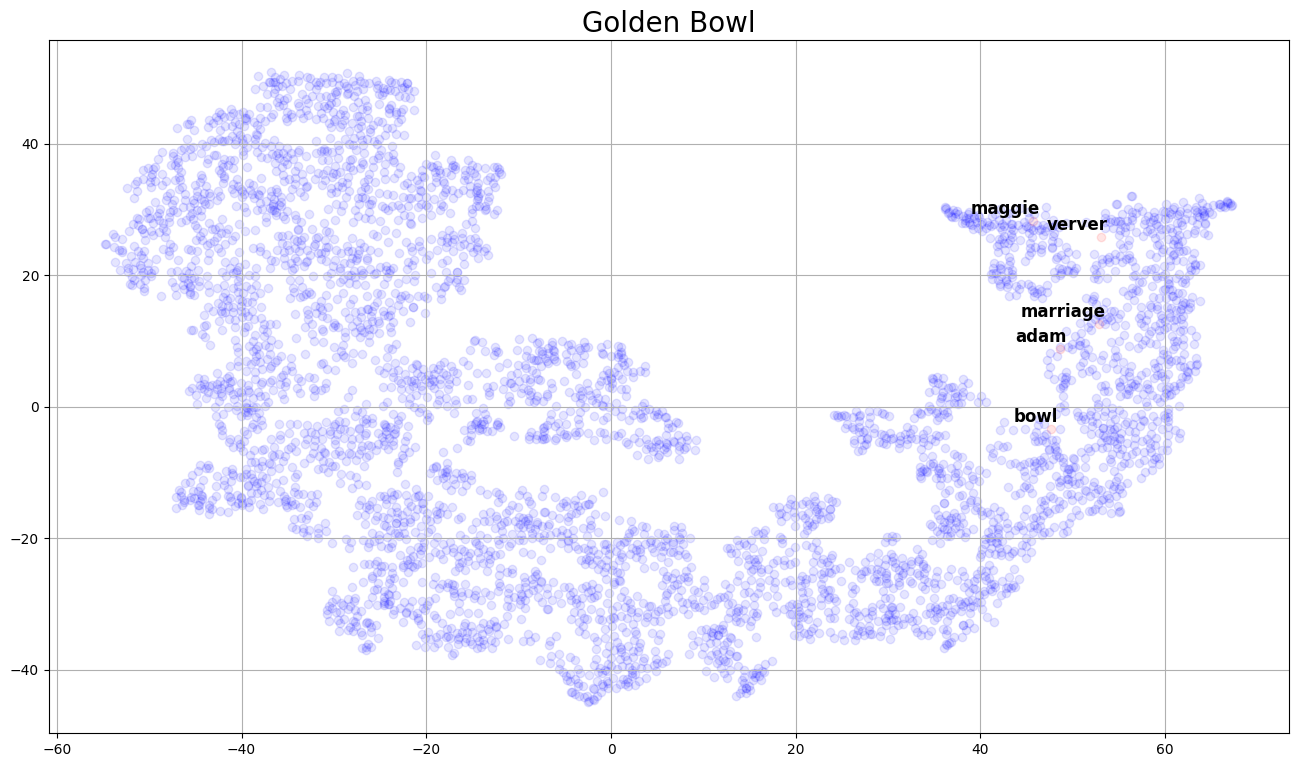

Number of points plotted: 4336


In [27]:
import matplotlib.pyplot as plt


def tsne_plot_2d(label, embeddings, words=[], a=1, highlight_words=['maggie', 'bowl', 'adam', 'verver', 'marriage']):
    plt.figure(figsize=(16, 9))

    # Extract x and y coordinates
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    # Plot each point and annotate highlighted words
    for i, word in enumerate(words):
        color = 'red' if word in highlight_words else 'blue'
        plt.scatter(x[i], y[i], color=color, alpha=a)
        if word in highlight_words:
            plt.annotate(word, alpha=1.0, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom',
                         size=12, weight='bold')

    # Set the title of the plot with the given label
    plt.title(label, fontsize=20)

    plt.grid(True)
    plt.show()

    # Print the number of points
    num_points = embeddings.shape[0]
    print("Number of points plotted:", num_points)

# Example usage
tsne_plot_2d('Golden Bowl', embeddings_model_2d_np, words_model, a=0.1)


In [28]:
num_points = len(embeddings_model)
print("Number of points plotted:", num_points)


Number of points plotted: 4336
